<a href="https://colab.research.google.com/github/Plashka320/-/blob/main/%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80_%D0%B2%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B2_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Введение в нейронные сети

# Оглавление
1. [Наивная реализация на numpy](#section1)   
  1.1. [Подготовка](#section1_1)       
  1.2. [Однослойная сеть](#section1_2)   
  1.3. [Двухслойная сеть](#section1_3)     
2. [Чуть более современное](#section2)     
  2.1. [Двухслойная сеть на PyTorch](#section2_1)    
  2.2. [Оптимизаторы](#section2_2)    

# 1. Наивная реализация на numpy <a name="section1"></a>

Попробуем написать все на numpy (sklearn применим только для генерации датасета)

## 1.1. Подготовка <a name="section1_1"></a>

In [ ]:
from sklearn.datasets import make_classification
import numpy as np

n_features = 30
n_samples = 200_000
data = make_classification(n_samples = n_samples, n_features =n_features, random_state = 42, n_redundant = 10)

Train/test split

In [ ]:
def train_test_split(data, test_size=0.33, seed=903):
  rng = np.random.default_rng(seed=seed)
  idx = rng.choice([True, False], size=data[0].shape[0], p=[1 - test_size, test_size])
  return (data[0][idx, :], data[1][idx]), (data[0][~idx, :], data[1][~idx])

In [ ]:
train, test = train_test_split(data)

Разобьем данные на батчи

In [ ]:
def make_batch(dataset, batch_size = 512):
  data_batched = []
  for k in range(0, dataset[0].shape[0] // batch_size + 1):
    idx_left, idx_right = k * batch_size, min((k + 1) * batch_size, dataset[0].shape[0])
    data_batched.append((dataset[0][idx_left:idx_right, :], dataset[1][idx_left:idx_right]))
  assert (len(data_batched) - 1) * batch_size + data_batched[-1][0].shape[0] == dataset[0].shape[0]
  return data_batched

In [ ]:
train_batched = make_batch(train)
test_batched = make_batch(test)

Инициализируем слои случайно

In [ ]:
def random_normal_init(input_size, output_size, seed = 903):
  rng = np.random.default_rng(seed=seed)
  return rng.normal(size = (input_size, output_size)) / np.sqrt(input_size)

Теперь давайте обсудим какой лосс будем оптимизировать в бинарной классификации
Как мы рассматривали в семинаре по линейным моделям, logloss и его вариации выводятся из ММП

$$ logloss = L(y_{true}|y_{pred}) =  -\dfrac{1}{N}. \sum_{i=1}^{N} [y^i_{true} \cdot log(y^i_{pred}) + (1-y^i_{true}) \cdot log(1-y^i_{pred})] $$

Давайте перепишем в виде векторов чтобы не тащить за собой индексы:

$$ logloss = L(y_{true}|y_{pred}) =  -\dfrac{1}{N}.[y^T_{true} \cdot log(y_{pred}) + (1-y_{true})^T \cdot log(1-y_{pred})] $$

Вооружившись лоссом давайте вспомним что мы с ним  делали в линейных моделях -- а мы брали градиент по тем параметрам, которые хотели оценить в модели.

Здесь эти параметры == веса нейронов наших слоев, и чтобы посчитать градиент, воспользуемся правилом производной сложной функции: сначала возьмем производную лосса по предиктам, затем производную предикта по весам последнего слоя, затем предпоследнего и так далее до первого



Итак, сначала посчитаем градиент лосса:

$$ \frac{\partial{L(y_{true}|y_{pred})}}{\partial{y_{pred}}}  = -\dfrac{1}{N}. (\dfrac{y_{true}}{y_{pred}}-\dfrac{(1-y_{true})}{(1-y_{pred})} )$$
$$ = -\dfrac{1}{N}. \dfrac{y^T_{true}(1-y_{pred}) - (1-y_{true})^Ty_{pred}}{y^T_{pred}(1-y_{pred})} $$
$$ = -\dfrac{1}{N}. \dfrac{y_{true}-y^T_{true}y_{pred} - y_{pred}+y^T_{true}y_{pred}}{y^T_{pred}(1-y_{pred})}  = - \dfrac{1}{N}. \dfrac{y_{true} - y_{pred}}{y^T_{pred}(1-y_{pred})} $$

Давайте поменяем знак:

$$ \dfrac{\partial{L(y_{true}|y_{pred})}}{\partial{y_{pred}}}   = - \dfrac{1}{N} { \dfrac{\sum(y_{true}- y^T_{pred})}{y^T_{pred}(1-y_{pred})} } = \dfrac{1}{N} { \dfrac{\sum(y_{pred}- y_{true})}{y^T_{pred}(1-y_{pred})} } $$

В коде выходит так (здесь считаем $y_{true}$ и $y_{pred}$ векторами ответов):

In [ ]:
EPS = 1e-12
def ll(y_true, y_pred):
  return -(np.matmul(y_true.T, np.log(y_pred + EPS)) + np.matmul((1 - y_true).T, np.log(1 - y_pred + EPS)))

def der_ll(y_true, y_pred):
  return np.mean(y_true - y_pred) / (np.matmul(y_pred.T, 1 - y_pred))

Здорово получилось! Теперь осталось посчитать производную $y_{pred}$ по весам первого слоя

В этом вводном занятии рассмотрим самые простые слои -- полносвзяные

Один полносвязный слой предсказывает применением функции активации (например, сигмоиды) к линейной функции от входа.

То есть для случая одного слоя:

$$y_{pred} = σ(Wx + b) = \sigma (b + \sum_{j=1}^N{w_j x})$$

Это снова композиция функций!      
Вспомним формулу сигмоиды и заодно ее производной, обозначив для краткости $Wx + b = g$:

$$\sigma (g) = \frac{1}{1 + e^{-g}} $$
$$\frac {\partial{\sigma(g)}}{\partial{g}} = - \frac{1}{(1 + e^{-g})^2} (- e^{-g}) = \frac{1}{1 + e^{-g}} \frac{e^{-g}}{1 + e^{-g}} = \frac{1}{1 + e^{-g}} \frac{e^{-g} + 1 -1}{1 + e^{-g}} = $$
$$= \frac{1}{1 + e^{-g}} (1 - \frac{1}{1 + e^{-g}}) = $$

$$=\sigma (g) (1 - \sigma (g)) $$

в коде:

In [ ]:
def sigmoid(g):
  return 1 / (1 + np.exp(-g))

Осталось взять всего две производные и написать общую формулу для градиента в случае однослойной сети:

$$\frac{\partial(Wx + b)}{\partial{w_j}} = x$$
$$\frac{\partial(Wx + b)}{\partial{b}} = 1$$
$$\frac{\partial{L}}{\partial{w_j}} = \dfrac{1}{N} { \dfrac{\sum(y_{pred}- y_{true})}{y^T_{pred}(1-y_{pred})} }y^T_{pred} (1 - y_{pred}) x $$
$$\frac{\partial{L}}{\partial{b}} = \dfrac{1}{N} { \dfrac{\sum(y_{pred}- y_{true})}{y^T_{pred}(1-y_{pred})} }y^T_{pred} (1 - y_{pred}) $$

для конкретной точки:

$$\frac{dL}{dw_j} = (y^{i}_{pred} - y^{i}_{true}) x_i $$
$$\frac{dL}{db} = y^{i}_{pred} - y^{i}_{true} $$

На этом месте не поленитесь и откройте семинар по линейным моделям!

Заметили отличие?

То есть полносвязная нейронная сеть с одним линейным слоем из одного нейрона и сигмоидной функции активации это просто логистическая регрессия!

##1.2. Однослойная сеть <a name="section1_2"></a>

In [ ]:
class nn_1_layer_linear:
  def __init__(self, first_size, step = 0.01):
    self.w0 = np.squeeze(random_normal_init(first_size, 1))
    self.b0 = random_normal_init(1, 1)[0][0]
    self.step = step
    return

  def forward(self, x):
    y_pred = np.dot(self.w0, x.T) + self.b0
    y_pred = np.squeeze(sigmoid(y_pred))
    return y_pred

  def total_loss(self, y_true, y_pred):
    return ll(y_true, y_pred)

  def update_weights(self, x, y_true):
    y_pred = self.forward(x)
    self.b0 = self.b0 - self.step * np.mean(y_pred - y_true)
    self.w0 = self.w0 - self.step * np.dot(y_pred - y_true, x)

  def train(self, x, y_true, verbose = False):
    self.update_weights(x, y_true)
    if verbose:
      print('loss: ', self.total_loss(y_true, self.forward(x)))

In [ ]:
len(train_batched)

262

In [ ]:
network = nn_1_layer_linear(n_features)
for i in range(50):
  if i % 2 == 0:
    network.train(train_batched[i][0], train_batched[i][1], verbose = True)
  else:
    network.train(train_batched[i][0], train_batched[i][1])

loss:  172.2966274918088
loss:  147.82503268029782
loss:  138.11659592969391
loss:  131.93021667742474
loss:  117.14028718673413
loss:  117.04834126475191
loss:  156.85716064694122
loss:  94.99384978345986
loss:  93.70735367426309
loss:  112.98144109157943
loss:  114.52514975047744
loss:  109.76187939650674
loss:  117.7654693697001
loss:  119.35633294542357
loss:  125.60615620112998
loss:  84.64478592485531
loss:  83.19388050415961
loss:  103.03797078320981
loss:  95.27971003600231
loss:  78.34058129525114
loss:  114.31203673990592
loss:  122.1014843416504
loss:  74.45655437014281
loss:  113.59591378695148
loss:  124.95883603509435


Качество на кусочке теста

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_batched[0][1], network.forward(test_batched[0][0]))

0.9705895826652617

## 1.3. Двухслойная сеть <a name="section1_3"></a>

Давайте попробуем сделать сеть в два слоя, и функцией активации первого слоя тоже будет сигмоида

$$\frac{\partial{L}}{\partial{w_j}} = \frac{1}{m} (y_{pred} - y_{true}) \sigma(w^0_j x_i + b^0) $$
$$\frac{\partial{L}}{\partial{b}} = \frac{1}{m} \sum{(y^{i}_{pred} - y^{i}_{true})} $$
$$\frac{\partial{L}}{\partial{w^0_j}} = (y_{pred} - y_{true}) w_j \sigma(w^0_j x + b^0) (1 - \sigma(w^0_j x + b^0) ) x_i$$
$$\frac{\partial{L}}{\partial{b^0}} = (y_{pred} - y_{true}) w_j \sigma(w^0_j x + b^0) (1 - \sigma(w^0_j x + b^0) ) $$




In [ ]:
class nn_2_layers_linear:
  def __init__(self, first_size, second_size, step = 0.01):
    self.w0 = random_normal_init(first_size, second_size)
    self.b0 = np.squeeze(random_normal_init(second_size, 1))
    self.w = np.squeeze(random_normal_init(second_size, 1))
    self.b = random_normal_init(1, 1)[0][0]
    self.step = step
    self.second_size = second_size
    self.first_size = first_size
    return

  def forward(self, x):
    y_pred = np.matmul(x, self.w0) + self.b0
    y_pred = sigmoid(y_pred)
    y_pred = np.matmul(y_pred, self.w) + self.b
    return np.squeeze(sigmoid(y_pred))

  def total_loss(self, y_true, y_pred):
    return ll(y_true, y_pred)

  def update_weights(self, x, y_true):
    y_pred = self.forward(x)
    error = y_pred - y_true
    s = sigmoid(np.matmul(x, self.w0) + self.b0)

    self.w = self.w - self.step * np.dot(error, s) / self.first_size
    self.b = self.b - self.step * np.mean(error)

    der_sigmoid_mult_by_error = (s * self.w ).T * (1 - s.T) * error

    self.w0 = self.w0 - self.step * np.matmul(x.T, der_sigmoid_mult_by_error.T) / self.first_size
    self.b0 = self.b0 - self.step * np.sum(der_sigmoid_mult_by_error.T, axis=0) / self.first_size


  def train(self, x, y_true, verbose = False, step = 0.01):
    self.step = step
    self.update_weights(x, y_true)
    if verbose:
      print('loss: ', self.total_loss(y_true, self.forward(x)))

In [ ]:
len(train_batched)

262

In [ ]:
network = nn_2_layers_linear(n_features, 15)
for i in range(len(train_batched)):
  if i % 10 == 0:
    network.train(train_batched[i][0], train_batched[i][1], verbose = True)
  else:
    network.train(train_batched[i][0], train_batched[i][1])

loss:  314.76725170027396
loss:  244.86090609986644
loss:  208.95963355357617
loss:  176.7539678984004
loss:  173.70686827618792
loss:  143.18919756326204
loss:  147.6774223511631
loss:  128.88344468034688
loss:  132.0404570247874
loss:  131.40430510832485
loss:  129.40542302125104
loss:  144.186194193682
loss:  126.14983108359203
loss:  123.54253602391138
loss:  114.01352955122718
loss:  116.80193723656467
loss:  120.98042401559302
loss:  113.88474304843822
loss:  130.1217560787498
loss:  110.25973648314738
loss:  110.26601688058557
loss:  97.35883207611127
loss:  92.76907460832464
loss:  110.6727232857079
loss:  108.50449508017779
loss:  121.11189977478583
loss:  87.39249772027786


Не похоже чтобы сеть стабильно сходилась!

Посмотрим на качество на кусочке теста:

In [ ]:
roc_auc_score(test_batched[9][1], network.forward(test_batched[9][0]))

0.9547362156057808

Примерно то же самое

Попробуем учиться дольше -- не просто прогоним все батчи, а еще и 10 раз повторим все заново!

In [ ]:
epochs = 10
for _ in range(epochs):
  for i in range(len(train_batched)):
    if i % 50 == 0:
      network.train(train_batched[i][0], train_batched[i][1], verbose = True)
    else:
      network.train(train_batched[i][0], train_batched[i][1])

loss:  107.16060038409798
loss:  93.65701076597549
loss:  115.76527419186436
loss:  111.42865410232007
loss:  108.16124332069215
loss:  120.68342523299397
loss:  106.23448544890337
loss:  91.6907283234205
loss:  115.40018853487646
loss:  111.19315507830456
loss:  107.85304086399896
loss:  120.55763447855111
loss:  105.45555494090507
loss:  90.69341058872513
loss:  114.72164400774054
loss:  110.71954078799098
loss:  107.07143616964174
loss:  119.9052195361306
loss:  104.10646807343997
loss:  89.61213161158176
loss:  113.44827544730066
loss:  109.90535868799866
loss:  105.85963101348361
loss:  118.74802587058298
loss:  102.38268766937412
loss:  88.36618419524162
loss:  111.79064030656758
loss:  108.75230263734599
loss:  104.35131954606169
loss:  117.06992737930109
loss:  100.39444541637755
loss:  86.91843817247083
loss:  109.82504807455419
loss:  107.16687946955432
loss:  102.57681949686528
loss:  114.80254402564563
loss:  98.09990979126152
loss:  85.17902829526479
loss:  107.52099117378

In [ ]:
roc_auc_score(test_batched[9][1], network.forward(test_batched[9][0]))

0.962076701207136

Качество улучшилось?

Прежде чем перейдем к ответу проведем еще небольшой эксперимент

Давайте попробуем проследить как меняется вес какого-н одного нейрона -- пусть это будет десятый в первом слое

In [ ]:
class nn_2_layers_linear_w0:
  def __init__(self, first_size, second_size, step = 0.01):
    self.w0 = random_normal_init(first_size, second_size)
    self.b0 = np.squeeze(random_normal_init(second_size, 1))
    self.w = np.squeeze(random_normal_init(second_size, 1))
    self.b = random_normal_init(1, 1)[0][0]
    self.step = step
    self.first_size = first_size
    self.second_size = second_size
    return

  def forward(self, x):
    y_pred = np.matmul(x, self.w0) + self.b0
    y_pred = sigmoid(y_pred)
    y_pred = np.matmul(y_pred, self.w) + self.b
    return np.squeeze(sigmoid(y_pred))

  def total_loss(self, y_true, y_pred):
    return ll(y_true, y_pred)

  def update_weights(self, x, y_true):
    y_pred = self.forward(x)
    error = y_pred - y_true
    s = sigmoid(np.matmul(x, self.w0) + self.b0)

    self.w = self.w - self.step * np.dot(error, s) / self.first_size
    self.b = self.b - self.step * np.mean(error)

    der_sigmoid_mult_by_error = (s * self.w ).T * (1 - s.T) * error

    self.w0 = self.w0 - self.step * np.matmul(x.T, der_sigmoid_mult_by_error.T) / self.first_size
    self.b0 = self.b0 - self.step * np.sum(der_sigmoid_mult_by_error.T, axis=0) / self.first_size

  def train(self, x, y_true, verbose = False, step = 0.01, out = (9, 0)):
    self.step = step
    self.update_weights(x, y_true)
    y_pred = self.forward(x)
    if verbose:
      return self.w0[out]

In [ ]:
network = nn_2_layers_linear_w0(n_features, 15)
epochs = 20
w0_9_0 = []
for _ in range(epochs):
  for i in range(len(train_batched)):
    w0_9_0.append(network.train(train_batched[i][0], train_batched[i][1], verbose = True))

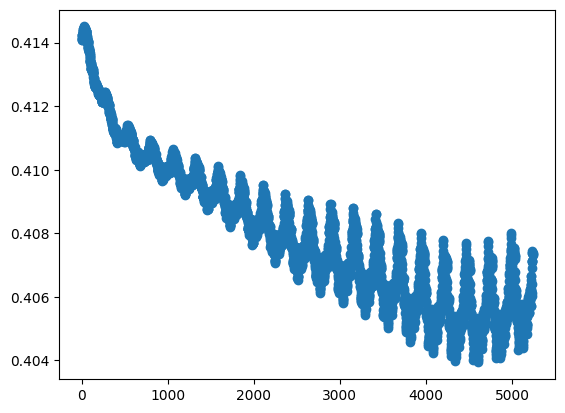

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(np.linspace(0, len(w0_9_0), len(w0_9_0)), w0_9_0)
plt.show()

Кажется, step надо было в какой-то момент начать уменьшать

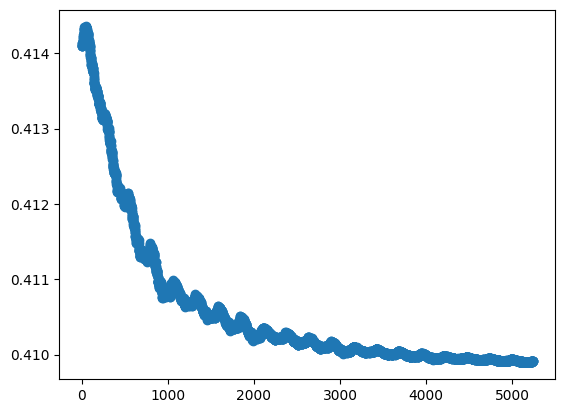

In [ ]:
network = nn_2_layers_linear_w0(n_features, 15)
epochs = 20
step = 0.01
w0_9_0 = []
for ep in range(epochs):
  if ep % 4 == 0:
    step /= 2
  for i in range(len(train_batched)):
    w0_9_0.append(network.train(train_batched[i][0], train_batched[i][1], verbose = True, step = step))
plt.scatter(np.linspace(0, len(w0_9_0), len(w0_9_0)), w0_9_0)
plt.show()

Качество на кусочке теста

In [ ]:
roc_auc_score(test_batched[9][1], network.forward(test_batched[9][0]))

0.9555450425015641

Размеры батчей у нас одинаковые (кроме последнего), поэтому возьмем просто ср арифметическое

0.9727313722188184


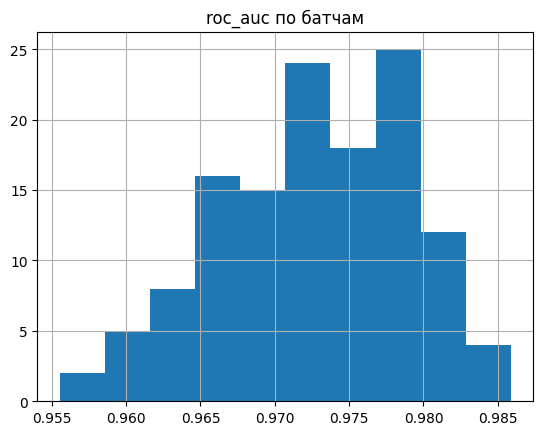

In [ ]:
import warnings
warnings.filterwarnings("ignore")
roc_auc_batched = []
for idx in range(len(test_batched)) :
  roc_auc_batched.append(roc_auc_score(test_batched[idx][1], network.forward(test_batched[idx][0])))
print(np.mean(roc_auc_batched))
import pandas as pd
pd.Series(roc_auc_batched).hist()
plt.title('roc_auc по батчам')
plt.show()

В случае одного слоя мы учили число весов, равное числу фичей (30)

Сейчас мы добавили слой с 30*15 = 450(!) весами!
Во втором слое 30 весов

Итого 450 + 15 = 465 весов учим
А еще смещения (b -- от слова bias) -- и их 15 + 1 = 16.     
Всего обучаем 465 + 16 = 481 параметр!


В таком пространстве нам уже нужен какой-то оптимизатор поумнее, например, с инерцией или изменением шага.
  

*   Или взять другую функцию активации? Гиперболический тангенс?
*   Добавить регуляризацию? Дропаут?
*   Нормализацию?
*   Раннюю остановку?
*   Изменить размер батча?
*   Нормализовывать батч? или слой?
*   Чуть поменять таргет via label smoothing?
*   Другой оптимизатор?
*   Планировщик изменения шага? (scheduler)
  

Посмотрим на эти и другие базовые приемы из библиотеки PyTorch в курсе по DL, а в качестве введения посмотрим как на качество сети может влиять выбор оптимизатора

# 2. Наивная реализация на PyTorch <a name="section2"></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
import math
torch.manual_seed(45)
torch.cuda.manual_seed(45)
torch.use_deterministic_algorithms(mode=True)

In [ ]:
from sklearn.datasets import make_classification
import numpy as np

n_features = 30
n_samples = 200_000
data = make_classification(n_samples = n_samples, n_features =n_features, random_state = 42, n_redundant = 10)

In [ ]:
# torch.utils.data.random_split(dataset, lengths)
def train_test_split(data, test_size=0.33, seed=903):
  rng = np.random.default_rng(seed=seed)
  idx = rng.choice([True, False], size=data[0].shape[0], p=[1 - test_size, test_size])
  return (data[0][idx, :], data[1][idx]), (data[0][~idx, :], data[1][~idx])

train, test = train_test_split(data)

In [ ]:
def make_batch(dataset, batch_size = 512):
  data_batched = []
  for k in range(0, dataset[0].shape[0] // batch_size + 1):
    idx_left, idx_right = k * batch_size, min((k + 1) * batch_size, dataset[0].shape[0])
    data_batched.append((dataset[0][idx_left:idx_right, :], dataset[1][idx_left:idx_right]))
  assert (len(data_batched) - 1) * batch_size + data_batched[-1][0].shape[0] == dataset[0].shape[0]
  return data_batched

train_batched = make_batch(train)
test_batched = make_batch(test)

## 2.1. Двухслойная сеть на PyTorch <a name="section2_1"></a>

In [ ]:
class TwoLayerFCNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.sigmoid(self.l1(x))
        x = F.sigmoid(self.l2(x))
        return x

In [ ]:
two_layer_fc_network = TwoLayerFCNet(n_features, 15, 1)
criterion = nn.BCELoss()
optimizer = optim.SGD(two_layer_fc_network.parameters(), lr = 0.1, momentum = 0.01)

for epoch in range(10):
    total_loss = 0
    for idx, batch in enumerate(train_batched):
        x, y_true = torch.Tensor(batch[0]), torch.Tensor(batch[1].reshape(-1,1))#.type(torch.LongTensor)
        optimizer.zero_grad()
        y_pred = two_layer_fc_network(x)
        assert len(y_pred) == len(y_true)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if idx % 100 == 0:
            print(f'loss: {total_loss / ((idx + 1)*len(batch)) :.2f}', f'{epoch} epoch, {idx + 1} batch')

loss: 0.35 0 epoch, 1 batch
loss: 0.27 0 epoch, 101 batch
loss: 0.21 0 epoch, 201 batch
loss: 0.11 1 epoch, 1 batch
loss: 0.11 1 epoch, 101 batch
loss: 0.11 1 epoch, 201 batch
loss: 0.10 2 epoch, 1 batch
loss: 0.10 2 epoch, 101 batch
loss: 0.10 2 epoch, 201 batch
loss: 0.10 3 epoch, 1 batch
loss: 0.10 3 epoch, 101 batch
loss: 0.10 3 epoch, 201 batch
loss: 0.10 4 epoch, 1 batch
loss: 0.10 4 epoch, 101 batch
loss: 0.10 4 epoch, 201 batch
loss: 0.10 5 epoch, 1 batch
loss: 0.10 5 epoch, 101 batch
loss: 0.10 5 epoch, 201 batch
loss: 0.10 6 epoch, 1 batch
loss: 0.10 6 epoch, 101 batch
loss: 0.10 6 epoch, 201 batch
loss: 0.10 7 epoch, 1 batch
loss: 0.10 7 epoch, 101 batch
loss: 0.10 7 epoch, 201 batch
loss: 0.10 8 epoch, 1 batch
loss: 0.10 8 epoch, 101 batch
loss: 0.10 8 epoch, 201 batch
loss: 0.10 9 epoch, 1 batch
loss: 0.10 9 epoch, 101 batch
loss: 0.10 9 epoch, 201 batch


измерим качество на одном батче из теста

In [ ]:
from sklearn.metrics import roc_auc_score
test_y_0 = two_layer_fc_network.forward(torch.Tensor(test_batched[0][0])).detach().numpy()
text_x_0 = test_batched[0][1]
roc_auc_score(text_x_0, test_y_0)

0.97335349000565

и на всех

0.9727536866821194


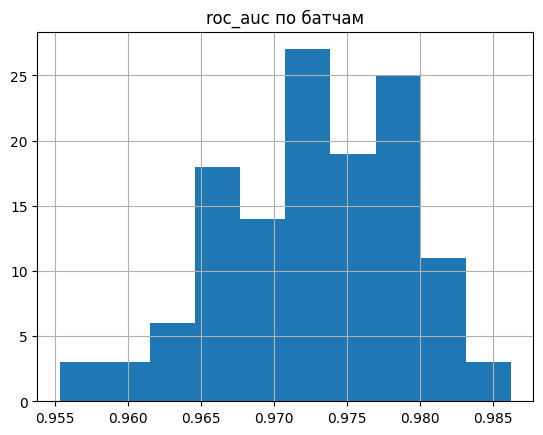

In [ ]:
import warnings
warnings.filterwarnings("ignore")
roc_auc_batched = []
for idx in range(len(test_batched)) :
  roc_auc_batched.append(roc_auc_score(test_batched[idx][1], two_layer_fc_network.forward(torch.Tensor(test_batched[idx][0])).detach().numpy()))
print(np.mean(roc_auc_batched))
import pandas as pd
pd.Series(roc_auc_batched).hist()
plt.title('roc_auc по батчам')
plt.show()

Не густо!

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(two_layer_fc_network)

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| l1.weight |    450     |
|  l1.bias  |     15     |
| l2.weight |     15     |
|  l2.bias  |     1      |
+-----------+------------+
Total Trainable Params: 481


481

Число параметров почти то же самое (выходных нейрона два а не один)

##2.2. Оптимизаторы  <a name="section2_2"></a>

Попробуем использовать разные оптимизаторы и замерим как будет меняться качество на тесте

In [ ]:
def check_quality(network, test_batched):
  roc_auc_total = []
  for idx in range(len(test_batched)) :
    roc_auc_total.append(roc_auc_score(test_batched[idx][1], network.forward(torch.Tensor(test_batched[idx][0])).detach().numpy()[:,1]))
  return np.mean(roc_auc_total)

In [ ]:
from tqdm import tqdm

In [ ]:
def train(network, train_batched, test_batched, optimizer, n_epochs = 20):
  test_quality = []
  criterion = nn.NLLLoss()
  for epoch in tqdm(range(n_epochs)):
    for batch in train_batched:
      x, y_true = torch.Tensor(batch[0]), torch.Tensor(batch[1]).type(torch.LongTensor)
      optimizer.zero_grad()
      y_pred = network(x)
      assert len(y_pred) == len(y_true)
      loss = criterion(y_pred, y_true)
      loss.backward()
      optimizer.step()
    test_quality.append([epoch, check_quality(network, test_batched)])
  return test_quality

In [ ]:
def make_optimizer(network, optimizer_name):
  if optimizer_name == 'SGD':
    return optim.SGD(network.parameters(), lr = 0.1, momentum = 0.01)
  elif optimizer_name == 'Adam':
    return optim.Adam(network.parameters(), lr = 0.1)
  elif optimizer_name == 'Adagrad':
    return optim.Adagrad(network.parameters(), lr = 0.1)
  elif optimizer_name == 'RMSprop':
    return optim.RMSprop(network.parameters(), lr = 0.1)

In [ ]:
%%time
res_dict = {}
optimizers = ['SGD', 'Adam', 'Adagrad', 'RMSprop']
for optimizer_name in tqdm(optimizers):
  print('\n\n', optimizer_name)
  network = TwoLayerFCNet(n_features, 15, 2)
  optimizer = make_optimizer(network, optimizer_name)
  res_dict[optimizer_name] = train(network, train_batched, test_batched, optimizer)

  0%|          | 0/4 [00:00<?, ?it/s]



 SGD



 25%|██▌       | 1/4 [00:12<00:36, 12.24s/it]



 Adam



 50%|█████     | 2/4 [00:24<00:24, 12.45s/it]



 Adagrad



 75%|███████▌  | 3/4 [00:36<00:12, 12.03s/it]



 RMSprop



100%|██████████| 4/4 [00:48<00:00, 12.12s/it]

CPU times: user 47 s, sys: 184 ms, total: 47.2 s
Wall time: 48.5 s


In [ ]:
import pandas as pd
df = pd.DataFrame()
for optimizer in res_dict:
  try:
    df['Epoch']
  except:
    df['Epoch'] = np.array(res_dict[optimizer])[:,0]
  df[f'{optimizer}'] = np.array(res_dict[optimizer])[:,1]

In [ ]:
import plotly.express as px
fig = px.line(df, x='Epoch', y=df.columns[1::])
fig.update_layout(
                  xaxis_title="epoch_num"
                  , yaxis_title="Roc_Auc"
                  , title="Динамика качества сети на тесте в зависимости от оптимизатора"
                  , height=600
                  , width=1200
                  , font_family="Arial"
                  , font_color="black"
                  , font_size = 16
                  , title_font_family="Times New Roman"
                  , title_font_size = 18
                  , title_font_color="black"
                  , separators=", .*"
)
fig.show()